# Imports

In [3]:
import h5py
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from dataloader import SimpleGraphDataLoader
from collections import Counter
from scipy.spatial.distance import pdist

# Load data

In [4]:
with h5py.File("/home/thomas/graph-diffusion-project/graphs_h5/graph_AntiFlourite_Ra2O_r5.h5", 'r') as file:
        edge_features = torch.tensor(file['edge_attributes'][:], dtype=torch.float32) # Edge attributes
        edge_indices = torch.tensor(file['edge_indices'][:], dtype=torch.long) # Edge (sparse) adjecency matrix
        node_features = torch.tensor(file['node_attributes'][:], dtype=torch.float32) # Node attributes

        xyz = node_features[:, 4:7]
        print(xyz.shape, xyz.max(), xyz.min())
        dists = torch.tensor(pdist(xyz, metric='euclidean'), dtype=torch.float32)
        print(dists.shape, dists.max(), dists.min())

torch.Size([23, 3]) tensor(5.3914) tensor(-5.3914)
torch.Size([253]) tensor(11.3660) tensor(3.1127)


In [8]:
txt_path = "/home/thomas/eq_ED_cond_sample_sample_0.txt"
with open(txt_path, 'r') as file:
    lines = file.readlines()
print(lines)

['135\n', '\n', 'C 0.0 0.0 0.0 \n', 'C 1.7971175 1.7971175 1.7971175 \n', 'C -1.7971175 -1.7971175 1.7971175 \n', 'C 1.7971175 -1.7971175 -1.7971175 \n', 'C -1.7971175 1.7971175 -1.7971175 \n', 'C 3.594235 0.0 0.0 \n', 'C 0.0 3.594235 0.0 \n', 'C 0.0 0.0 3.594235 \n', 'C 0.0 -3.594235 0.0 \n', 'C -3.594235 0.0 0.0 \n', 'C 0.0 0.0 -3.594235 \n', 'C 0.0 3.594235 3.594235 \n', 'C 3.594235 0.0 3.594235 \n', 'C 3.594235 3.594235 0.0 \n', 'C 0.0 3.594235 -3.594235 \n', 'C -3.594235 0.0 3.594235 \n', 'C -3.594235 3.594235 0.0 \n', 'C 3.594235 -3.594235 0.0 \n', 'C 3.594235 0.0 -3.594235 \n', 'C 0.0 -3.594235 3.594235 \n', 'C -3.594235 0.0 -3.594235 \n', 'C 0.0 -3.594235 -3.594235 \n', 'C -3.594235 -3.594235 0.0 \n', 'C 1.7971175 -5.3913527 1.7971175 \n', 'C 1.7971175 -1.7971175 5.3913527 \n', 'C 1.7971175 1.7971175 -5.3913527 \n', 'C -5.3913527 1.7971175 1.7971175 \n', 'C -1.7971175 1.7971175 5.3913527 \n', 'C -1.7971175 5.3913527 1.7971175 \n', 'C 5.3913527 1.7971175 -1.7971175 \n', 'C 1.797

In [46]:
n_samples = len(lines) // 137
mols = []
for i in range(n_samples):
    atoms = lines[i*137:(i+1)*137] # Fetch the lines corresponding to the atoms
    atoms = atoms[2:] # Remove header
    mol = np.array([atom.split()[1:] for atom in atoms], dtype=np.float32) # Convert to numpy array
    mols.append(mol)
np.array(mols).shape, np.arange(401).shape

((401, 135, 3), (401,))

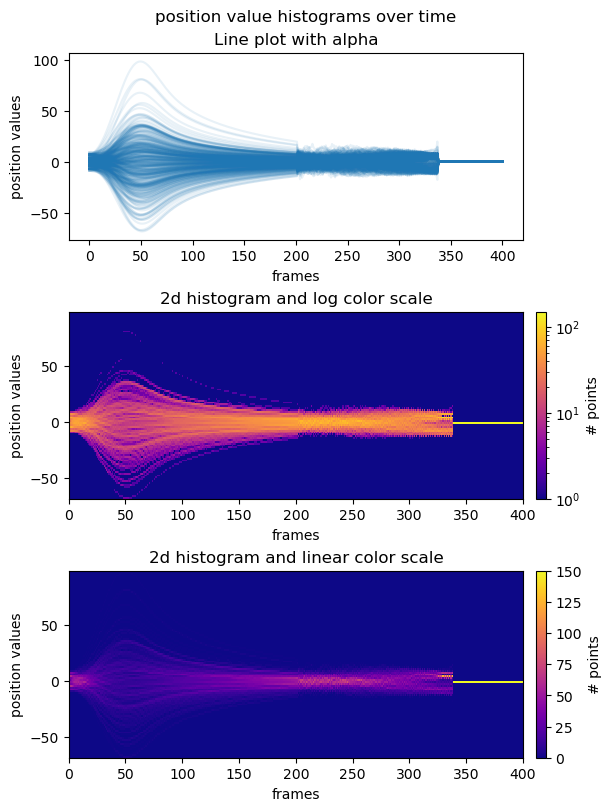

In [63]:
from copy import copy
import time

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(nrows=3, figsize=(6, 8), layout='constrained')
fig.suptitle("position value histograms over time")
x = np.arange(401)
Y = np.array(mols).reshape(len(mols), -1).T
Y = np.nan_to_num(Y)

axes[0].plot(x, Y.T, color="C0", alpha=0.1)
axes[0].set_title("Line plot with alpha")
axes[0].set_xlabel("frames")
axes[0].set_ylabel("position values")

num_fine = 401
num_series = Y.shape[0]
x_fine = np.linspace(x.min(), x.max(), num_fine)
y_fine = np.empty((num_series, num_fine), dtype=float)
for i in range(num_series):
    y_fine[i, :] = np.interp(x_fine, x, Y[i, :])
y_fine = y_fine.flatten()
x_fine = np.matlib.repmat(x_fine, num_series, 1).flatten()

cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmax=1.5e2), rasterized=True)
fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
axes[1].set_title("2d histogram and log color scale")
axes[1].set_xlabel("frames")
axes[1].set_ylabel("position values")

# Same data but on linear color scale
pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
axes[2].set_title("2d histogram and linear color scale")
axes[2].set_xlabel("frames")
axes[2].set_ylabel("position values")

plt.show()

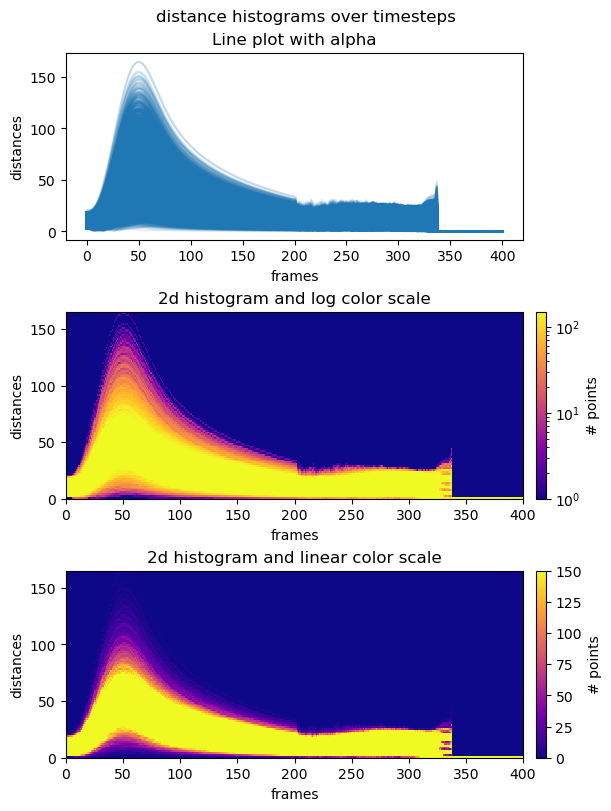

In [64]:
from copy import copy
import time

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(nrows=3, figsize=(6, 8), layout='constrained')
fig.suptitle("distance histograms over timesteps")
x = np.arange(401)
dists = []
for mol in mols:
    mol = np.nan_to_num(mol)
    dist = pdist(mol)
    dists.append(dist)
Y = np.array(dists).T

axes[0].plot(x, Y.T, color="C0", alpha=0.1)
axes[0].set_title("Line plot with alpha")
axes[0].set_xlabel("frames")
axes[0].set_ylabel("distances")

num_fine = 401
num_series = Y.shape[0]
x_fine = np.linspace(x.min(), x.max(), num_fine)
y_fine = np.empty((num_series, num_fine), dtype=float)
for i in range(num_series):
    y_fine[i, :] = np.interp(x_fine, x, Y[i, :])
y_fine = y_fine.flatten()
x_fine = np.matlib.repmat(x_fine, num_series, 1).flatten()

cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmax=1.5e2), rasterized=True)
fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
axes[1].set_title("2d histogram and log color scale")
axes[1].set_xlabel("frames")
axes[1].set_ylabel("distances")

# Same data but on linear color scale
pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
axes[2].set_title("2d histogram and linear color scale")
axes[2].set_xlabel("frames")
axes[2].set_ylabel("distances")

plt.show()

In [76]:
def make_histogram_single(positions, save_path, plot_positions=True):
    """
    Function to make a histogram of positions or distances between atoms
    args:
        positions: torch.tensor of shape (frames, n_atoms, 3)
        save_path: str, path to save the histogram
        plot_positions: bool, if True plot positions, else plot distances
    """
    fig, axes = plt.subplots(nrows=3, figsize=(6, 8), layout='constrained')
    if plot_positions:
        fig.suptitle("position value histograms over time")
        axes[1].set_ylabel("position values")
        axes[0].set_ylabel("position values")
        axes[2].set_ylabel("position values")
        x = np.arange(positions.shape[0])
        Y = positions.reshape(positions.shape[0], -1).T
        Y = np.nan_to_num(Y)
    else:
        fig.suptitle("distance histograms over time")
        axes[1].set_ylabel("distances")
        axes[0].set_ylabel("distances")
        axes[2].set_ylabel("distances")
        x = np.arange(positions.shape[0])
        Y = torch.cdist(positions, positions, p=2).reshape(positions.shape[0], -1).T
        Y = np.nan_to_num(Y)

    axes[0].plot(x, Y.T, color="C0", alpha=0.1)
    axes[0].set_title("Line plot with alpha")
    axes[0].set_xlabel("frames")

    num_fine = positions.shape[0]
    num_series = Y.shape[0]
    x_fine = np.linspace(x.min(), x.max(), num_fine)
    y_fine = np.empty((num_series, num_fine), dtype=float)
    for i in range(num_series):
        y_fine[i, :] = np.interp(x_fine, x, Y[i, :])
    y_fine = y_fine.flatten()
    x_fine = np.matlib.repmat(x_fine, num_series, 1).flatten()

    cmap = copy(plt.cm.plasma)
    cmap.set_bad(cmap(0))
    h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
    pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                             norm=LogNorm(vmax=1.5e2), rasterized=True)
    fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
    axes[1].set_title("2d histogram and log color scale")
    axes[1].set_xlabel("frames")

    # Same data but on linear color scale
    pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                             vmax=1.5e2, rasterized=True)
    fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
    axes[2].set_title("2d histogram and linear color scale")
    axes[2].set_xlabel("frames")

    plt.show()

In [82]:
torch.cdist(mol_t, mol_t, p=2).shape

torch.Size([401, 135, 135])

In [79]:
mol_t = torch.tensor(mols)
mol_t.shape

torch.Size([401, 135, 3])

In [143]:
mol_paths = glob.glob("/home/thomas/graph-diffusion-project/graphs_h5/*")
print(len(mol_paths))

1728


In [144]:
def load_structure(path):

    with h5py.File(path, 'r') as file:
        edge_features = torch.tensor(file['edge_attributes'][:], dtype=torch.float32) # Edge attributes
        edge_indices = torch.tensor(file['edge_indices'][:], dtype=torch.long) # Edge (sparse) adjecency matrix
        node_features = torch.tensor(file['node_attributes'][:], dtype=torch.float32) # Node attributes

        r = file['r'][...] # Real space (x-axis)
        pdf = file['pdf'][...] # G(r) (y-axis)

        # Here you can do some normalisation of the node features and perhaps pick out which you want to include.

        graph = Data(x = node_features, y = pdf, edge_attr = edge_features, edge_index = edge_indices)
    return graph

In [145]:
loader = DataLoader([load_structure(path) for path in mol_paths], batch_size=1, shuffle=True)

In [146]:
loader = [d for d in loader if d.x.shape[0] == 23]

In [147]:
len([d for d in loader if d.x.shape[0] <= 23])

3

In [148]:
g = loader[0]
print(g)

DataBatch(x=[23, 7], edge_index=[2, 56], edge_attr=[56], y=[1], batch=[23], ptr=[2])


In [149]:
import pandas as pd
from mendeleev import element

In [150]:
def xyz_to_str(xyz, atom_species=None):
    """
    Write a string in format ovito can read
    args:
        xyz: np.array of shape (n_atoms, 3)
        atom_species: np.array of shape (n_atoms, 1)
    returns:
        s: string in ovito format
    """
    n_atoms = xyz.shape[0]
    if atom_species is None:
        atom_species = np.array(["C"]*n_atoms).reshape(-1, 1)

    # if atom_species is number, convert to atomic symbol
    if atom_species.dtype != str:
        atom_species = np.array(
            [element(int(atom)).symbol if atom else atom for atom in atom_species]).reshape(-1, 1)

    s = ""
    vals = np.concatenate((atom_species, xyz), axis=1)

    # Number of atoms
    s += str(n_atoms) + "\n"
    
    # Comment line, just keep empty for now
    s += "\n"
    
    # Coordinates for each atom
    for atom, x, y, z in vals:
        s += f"{atom} {x} {y} {z} \n"

    return s


def save_to_csv(file_name, s):
    with open(file_name, "w") as f:
        f.write(s)

In [154]:
# Find the path to a graph with 23 nodes
for p in mol_paths:
    g = load_structure(p)
    if g.x.shape[0] == 23:
        print(p)
        break

/home/thomas/graph-diffusion-project/graphs_h5/graph_AntiFlourite_Ra2O_r5.h5
